# Extracting unique values and sessions

Firstly, we need to import libraries for constructing HTTP queries that are authenticated with HTTP digest.

In [194]:
import requests
from requests.auth import HTTPDigestAuth

Also, define authentication params, so we can reuse them as variables.

In [195]:
user="vagrant"
passwd="vagrant"

In [196]:
auth=HTTPDigestAuth(user, passwd)

## Uniq

Supported query parameters are documented here:
* https://github.com/aol/moloch/wiki/API#uniquetxt

Then construct an example query that is limited to dns traffic.

In [197]:
query = {
    "expression": "protocols == dns",
    "exp": "dns.host"
}

In [198]:
resp = requests.get("http://192.168.10.13:8005/unique.txt", params=query, auth=auth)

In [199]:
print(resp.text)

berylia.org
self-signed.badssl.com
testmyids.com
star-mini.c10r.facebook.com
www.facebook.com
sysadminnid.tumblr.com
dualstack.python.map.fastly.net
pypi.python.org
neti.ee
dualstack.r.ssl.global.fastly.net
files.pythonhosted.org
pypi.org



We can limit the query to last N hours.

In [200]:
query = {
    "expression": "protocols == dns",
    "exp": "dns.host",
    "date": 2,
}
resp = requests.get("http://192.168.10.13:8005/unique.txt", params=query, auth=auth)

Alternatively, we can specify time range as unix epoch. A specific range can be created in python like this:

In [201]:
import datetime as dt
start = int(dt.datetime.strptime('04/16/2019 17:00:00', '%m/%d/%Y %H:%M:%S').strftime("%s"))
end = int(dt.datetime.strptime('04/16/2019 18:00:00', '%m/%d/%Y %H:%M:%S').strftime("%s"))

Or to get an inverval T backwards from current time. Example creates interval of 15 minutes

In [202]:
end = int(dt.datetime.now().strftime("%s"))
start = end - 15*60

In [203]:
query = {
    "expression": "protocols == dns",
    "exp": "dns.host",
    "startTime": start,
    "stopTime": end,
}
resp = requests.get("http://192.168.10.13:8005/unique.txt", params=query, auth=auth)
resp = resp.text.split("\n")

In [204]:
print(resp)

['berylia.org', 'sysadminnid.tumblr.com', 'self-signed.badssl.com', 'testmyids.com', 'star-mini.c10r.facebook.com', 'www.facebook.com', '']


We can also extract the occurrence counts.

In [205]:
query = {
    "expression": "protocols == dns",
    "exp": "dns.host",
    "startTime": start,
    "stopTime": end,
    "counts": 1,
}
resp = requests.get("http://192.168.10.13:8005/unique.txt", params=query, auth=auth)
resp = resp.text.split("\n")

In [206]:
print(resp)

['berylia.org, 32', 'sysadminnid.tumblr.com, 16', 'self-signed.badssl.com, 15', 'testmyids.com, 15', 'star-mini.c10r.facebook.com, 13', 'www.facebook.com, 13', '']


Turning it into python dictionary would likely be more useful.

In [207]:
data = {}
for r in resp:
    if len(r) > 0:
        bits = r.split(",")
        data[bits[0]] = int(bits[1])

In [208]:
data

{'berylia.org': 32,
 'sysadminnid.tumblr.com': 16,
 'self-signed.badssl.com': 15,
 'testmyids.com': 15,
 'star-mini.c10r.facebook.com': 13,
 'www.facebook.com': 13}

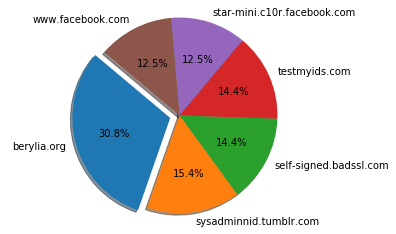

In [209]:
import matplotlib.pyplot as plt

#f = plt.figure()
# Data to plot
labels = data.keys()
sizes = data.values()
# separate slices that exceed some value
explode = [0.1 if val > 20 else 0 for val in sizes]
explode[0] = 0.1

# Plot
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

#f.savefig('/vagrant/plot.pdf', bbox_inches='tight')

Suppose we wanted to write a script that crawls all indexed data from past 4 hours in 1 minute increments that would memorize perviously seen values. Previously unobserved values should be printed with human readable of that bucket.

In [210]:
end = int(dt.datetime.now().strftime("%s"))
maximum = end
start = end - 4*60*60
items = []
while maximum > start:
    end = start + 60
    resp = requests.get("http://192.168.10.13:8005/unique.txt", params={
        "exp": "dstPort",
        "startTime": start,
        "stopTime": end,
    }, auth=auth)
    resp = resp.text.split("\n")
    resp = [r for r in resp if len(r) > 0]
    for item in resp:
        if item not in items:
            readable = dt.datetime.utcfromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S')
            print("{} first occurrence of {}".format(readable, item))
            items.append(item)
    start = end

2019-05-22 08:52:09 first occurrence of 53
2019-05-22 08:52:09 first occurrence of 443
2019-05-22 08:52:09 first occurrence of 80
2019-05-22 08:52:09 first occurrence of 8888
2019-05-22 08:52:09 first occurrence of 57621
2019-05-22 08:58:09 first occurrence of 0
2019-05-22 09:00:09 first occurrence of 67
2019-05-22 09:00:09 first occurrence of 68
2019-05-22 11:06:09 first occurrence of 8005
2019-05-22 11:06:09 first occurrence of 60406
2019-05-22 11:06:09 first occurrence of 60410
2019-05-22 11:06:09 first occurrence of 60416
2019-05-22 11:06:09 first occurrence of 60418
2019-05-22 12:20:09 first occurrence of 34480
2019-05-22 12:22:09 first occurrence of 34546
2019-05-22 12:48:09 first occurrence of 35456
2019-05-22 12:50:09 first occurrence of 35510


Note that `dstPort` was chosen as aggregated field only because vagrant box lacks real traffic. Doing this query over more traditional IOC fields, such as source IP addresses, JA3 hashes, user-agents, URI fields, etc would be much more useful. 

## Sessions

We have a list of unique domains. And would like to extract all sessions for each domain from last 5 minutes. Useful for reducing manual work when exploring, or for generating reports.

In [211]:
query = {
    "expression": "protocols == dns",
    "exp": "dns.host",
    "date": 1,
}
resp = requests.get("http://192.168.10.13:8005/unique.txt", params=query, auth=auth)
domains = [r for r in resp.text.split("\n") if len(r) > 0]
domains

['berylia.org',
 'self-signed.badssl.com',
 'testmyids.com',
 'star-mini.c10r.facebook.com',
 'www.facebook.com',
 'sysadminnid.tumblr.com',
 'dualstack.python.map.fastly.net',
 'pypi.python.org',
 'neti.ee',
 'dualstack.r.ssl.global.fastly.net',
 'files.pythonhosted.org',
 'pypi.org']

`fields` parameter can be used to customize resulting CSV.

In [212]:
end = int(dt.datetime.now().strftime("%s"))
start = end - 5*60

resps = {}
for d in domains:
    r = requests.get("http://192.168.10.13:8005/sessions.csv", params={
        "startTime": start,
        "stopTime": end,
        "expression": "host.dns == {}".format(d),
        "fields": ",".join([
            "srcIp",
            "dstIp",
            "communityId",
            "dns.status",
            "srcBytes",
            "dstBytes"
        ])
    }, auth=auth)
    resps[d] = r.text

In [214]:
for k, v in resps.items():
    print("----{}-----".format(k))
    print(v)

----berylia.org-----
Src IP, Dst IP, Community Id, Status Code, Src Bytes, Dst Bytes
10.0.2.15,8.8.8.8,1:C1NNXm+xTZ2XKoN//wHi5fFQn0w=,"NOERROR",94,132
10.0.2.15,1.1.1.1,1:v0rw20QsmBSk3kt9TFz7FeLNaRY=,"NOERROR",94,164
10.0.2.15,1.1.1.1,1:EWHrZX7VDnuPyizwgCqkjC68qmE=,"NOERROR",94,164
10.0.2.15,8.8.8.8,1:G9HUkcGorfHFpGn9cW5DclIOYtI=,"NOERROR",94,132
10.0.2.15,1.1.1.1,1:db3Avykvp8HY1MWRmBiP0YIeXvw=,"NOERROR",94,164
10.0.2.15,8.8.8.8,1:Er1+OOCF8yGNpdLTvvZYhPjcs3k=,"NOERROR",94,132
10.0.2.15,1.1.1.1,1:VEb/gaOMjrlHrUQrcflYGetGQ4A=,"NOERROR",94,164
10.0.2.15,1.1.1.1,1:+0ZDbtyhMqVWeOx08Gpw5RLvngE=,"NOERROR",94,164

----self-signed.badssl.com-----
Src IP, Dst IP, Community Id, Status Code, Src Bytes, Dst Bytes
10.0.2.15,1.1.1.1,1:8UZrL3KVTOF3EZrcGqFLxX2215E=,"NOERROR",164,553
10.0.2.15,1.1.1.1,1:vW8hYLkhXrdxModrnHofO7DOjAg=,"NOERROR",164,553
10.0.2.15,1.1.1.1,1:evuWPfFpU4ZnbJeBsPBD2bi1OXc=,"NOERROR",164,553

----testmyids.com-----
Src IP, Dst IP, Community Id, Status Code, Src Bytes, Dst Bytes
1

# Tasks

* Write a script that extracts all TLS certificate alternative names into a python list;
    * For each tls alternative name, extract Issuer and all individual sessions from past hour;
* LS exercise took place on April 10-11 2019 with April 9 being prep day, write following scripted queries;
    * Extract all unique JA3 hashes from 1 day interval;
        * For each distinct JA3 hash, extract unique source IP addresses that originate from simulated internet;
        * Investigate those groups, which might be malicious, which benign?
    * Extract unique HTTP user-agents and URI paths;
        * Extract sessions that contain remote code execution;